In [1]:
#!/isr/bin/env python

from keras.models import Sequential
from keras.models import Model
import matplotlib
%matplotlib inline
#matplotlib.use('Agg')
from keras.models import model_from_json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import c3d_model
import sys
import keras.backend as K
from keras.layers.core import Dense
dim_ordering = K.image_dim_ordering()
print("[Info] image_dim_order (from default ~/.keras/keras.json)={}".format(
        dim_ordering))
backend = dim_ordering

/home/ljames/py-3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[Info] image_dim_order (from default ~/.keras/keras.json)=tf


In [2]:
def diagnose(data, verbose=True, label='input', plots=False, backend='tf'):
    # Convolution3D?
    if data.ndim > 2:
        if backend == 'th':
            data = np.transpose(data, (1, 2, 3, 0))
        #else:
        #    data = np.transpose(data, (0, 2, 1, 3))
        min_num_spatial_axes = 10
        max_outputs_to_show = 3
        ndim = data.ndim
        print("[Info] {}.ndim={}".format(label, ndim))
        print("[Info] {}.shape={}".format(label, data.shape))
        for d in range(ndim):
            num_this_dim = data.shape[d]
            if num_this_dim >= min_num_spatial_axes: # check for spatial axes
                # just first, center, last indices
                range_this_dim = [0, num_this_dim/2, num_this_dim - 1]
            else:
                # sweep all indices for non-spatial axes
                range_this_dim = range(num_this_dim)
            for i in range_this_dim:
                new_dim = tuple([d] + range(d) + range(d + 1, ndim))
                sliced = np.transpose(data, new_dim)[i, ...]
                print("[Info] {}, dim:{} {}-th slice: "
                      "(min, max, mean, std)=({}, {}, {}, {})".format(
                              label,
                              d, i,
                              np.min(sliced),
                              np.max(sliced),
                              np.mean(sliced),
                              np.std(sliced)))
        if plots:
            # assume (l, h, w, c)-shaped input
            if data.ndim != 4:
                print("[Error] data (shape={}) is not 4-dim. Check data".format(
                        data.shape))
                return
            l, h, w, c = data.shape
            if l >= min_num_spatial_axes or \
                h < min_num_spatial_axes or \
                w < min_num_spatial_axes:
                print("[Error] data (shape={}) does not look like in (l,h,w,c) "
                      "format. Do reshape/transpose.".format(data.shape))
                return
            nrows = int(np.ceil(np.sqrt(data.shape[0])))
            # BGR
            if c == 3:
                for i in range(l):
                    mng = plt.get_current_fig_manager()
                    mng.resize(*mng.window.maxsize())
                    plt.subplot(nrows, nrows, i + 1) # doh, one-based!
                    im = np.squeeze(data[i, ...]).astype(np.float32)
                    im = im[:, :, ::-1] # BGR to RGB
                    # force it to range [0,1]
                    im_min, im_max = im.min(), im.max()
                    if im_max > im_min:
                        im_std = (im - im_min) / (im_max - im_min)
                    else:
                        print("[Warning] image is constant!")
                        im_std = np.zeros_like(im)
                    plt.imshow(im_std)
                    plt.axis('off')
                    plt.title("{}: t={}".format(label, i))
                plt.show()
                #plt.waitforbuttonpress()
            else:
                for j in range(min(c, max_outputs_to_show)):
                    for i in range(l):
                        mng = plt.get_current_fig_manager()
                        mng.resize(*mng.window.maxsize())
                        plt.subplot(nrows, nrows, i + 1) # doh, one-based!
                        im = np.squeeze(data[i, ...]).astype(np.float32)
                        im = im[:, :, j]
                        # force it to range [0,1]
                        im_min, im_max = im.min(), im.max()
                        if im_max > im_min:
                            im_std = (im - im_min) / (im_max - im_min)
                        else:
                            print("[Warning] image is constant!")
                            im_std = np.zeros_like(im)
                        plt.imshow(im_std)
                        plt.axis('off')
                        plt.title("{}: o={}, t={}".format(label, j, i))
                    plt.show()
                    #plt.waitforbuttonpress()
    elif data.ndim == 1:
        print("[Info] {} (min, max, mean, std)=({}, {}, {}, {})".format(
                      label,
                      np.min(data),
                      np.max(data),
                      np.mean(data),
                      np.std(data)))
        print("[Info] data[:10]={}".format(data[:10]))

    return

In [11]:
def main():
    show_images = False
    diagnose_plots = False
    model_dir = './models'
    global backend

    # override backend if provided as an input arg
    # Removing this because sys.argv has many values for jupyter notebooks
    """
    if len(sys.argv) > 1:
        if 'tf' in sys.argv[1].lower():
            backend = 'tf'
        else:
            backend = 'th'
    """
    print("[Info] Using backend={}".format(backend))

    if backend == 'th':
        model_weight_filename = os.path.join(model_dir, 'sports1M_weights_th.h5')
        model_json_filename = os.path.join(model_dir, 'sports1M_weights_th.json')
    else:
        model_weight_filename = os.path.join(model_dir, 'sports1M_weights_tf.h5')
        model_json_filename = os.path.join(model_dir, 'sports1M_weights_tf.json')

    print("[Info] Reading model architecture...")
    model = model_from_json(open(model_json_filename, 'r').read())
    print(model.summary())

    # visualize model
    model_img_filename = os.path.join(model_dir, 'c3d_model.png')
    if not os.path.exists(model_img_filename):
        from keras.utils import plot_model
        plot_model(model, to_file=model_img_filename)
        
        
    

    

    print("[Info] Loading model weights...")
    model.load_weights(model_weight_filename)
    print("[Info] Loading model weights -- DONE!")
    model.compile(loss='mean_squared_error', optimizer='sgd')
    
        # Change output layer
    #model = c3d_model.get_model(backend=backend)
    model.layers.pop()
    new_out = Dense(2, activation='softmax', name='new_fc8')(model.layers[-1].output)
    model2 = Model(model.input, output=[new_out])
    model2.compile(loss='mean_squared_error', optimizer='sgd')
    print(model2.summary())

    print("[Info] Loading labels...")
    with open('sports1m/labels.txt', 'r') as f:
        labels = [line.strip() for line in f.readlines()]
    print('Total labels: {}'.format(len(labels)))

    print("[Info] Loading a sample video...")
    cap = cv2.VideoCapture('dM06AMFLsrc.mp4')

    vid = []
    while True:
        ret, img = cap.read()
        if not ret:
            break
        vid.append(cv2.resize(img, (171, 128)))
    vid = np.array(vid, dtype=np.float32)
    
    

    #plt.imshow(vid[2000]/256)
    #plt.show()

    # sample 16-frame clip
    #start_frame = 100
    start_frame = 2000
    X = vid[start_frame:(start_frame + 16), :, :, :]
    #diagnose(X, verbose=True, label='X (16-frame clip)', plots=show_images)

    # subtract mean
    mean_cube = np.load('models/train01_16_128_171_mean.npy')
    mean_cube = np.transpose(mean_cube, (1, 2, 3, 0))
    #diagnose(mean_cube, verbose=True, label='Mean cube', plots=show_images)
    X -= mean_cube
    #diagnose(X, verbose=True, label='Mean-subtracted X', plots=show_images)

    # center crop
    X = X[:, 8:120, 30:142, :] # (l, h, w, c)
    #diagnose(X, verbose=True, label='Center-cropped X', plots=show_images)

    if backend == 'th':
        X = np.transpose(X, (3, 0, 1, 2)) # input_shape = (3,16,112,112)
    else:
        pass                              # input_shape = (16,112,112,3)

    # get activations for intermediate layers if needed
    inspect_layers = [
    #    'fc6',
    #    'fc7',
        ]
    for layer in inspect_layers:
        int_model = c3d_model.get_int_model(model=model, layer=layer, backend=backend)
        int_output = int_model.predict_on_batch(np.array([X]))
        int_output = int_output[0, ...]
        print("[Debug] at layer={}: output.shape={}".format(layer, int_output.shape))
        diagnose(int_output,
                 verbose=True,
                 label='{} activation'.format(layer),
                 plots=diagnose_plots,
                 backend=backend)

    # inference
    output = model2.predict_on_batch(np.array([X]))

    # show results
    print('Saving class probabilitities in probabilities.png')
    plt.plot(output[0])
    plt.title('Probability')
    plt.savefig("probabilities.png")
    print('Position of maximum probability: {}'.format(output[0].argmax()))
    print('Maximum probability: {:.5f}'.format(max(output[0])))
    print('Corresponding label: {}'.format(labels[output[0].argmax()]))

    # sort top five predictions from softmax output
    top_inds = output[0].argsort()[::-1][:5]  # reverse sort and take five largest items
    print('\nTop 5 probabilities and labels:')
    for i in top_inds:
        print('{1}: {0:.5f}'.format(output[0][i], labels[i]))

[Info] Using backend=tf
[Info] Reading model architecture...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769728   
_________________________________________________________________
pool3 (MaxPooli

/home/ljames/py-3.5/lib/python3.5/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("co..., outputs=[<tf.Tenso...)`


Saving class probabilitities in probabilities.png
Position of maximum probability: 1
Maximum probability: 0.65081
Corresponding label: boxing

Top 5 probabilities and labels:
boxing: 0.65081
boomerang: 0.34919


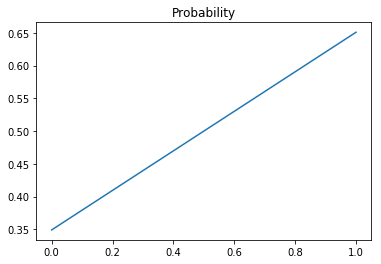

In [12]:
if __name__ == '__main__':
    main()